In [5]:
import numpy as np
import os
from datetime import datetime
import nibabel as ni
import random
import matplotlib.pyplot as plt

In [6]:
def load_nii_file(file_path):
    data = ni.load(file_path)
    volume = np.nan_to_num(data.get_data().squeeze())
    return volume

def load_files(file_paths, d_type=None):
    images = []
    for path in file_paths:
        if d_type == None:
            images.append(load_nii_file(path))
        else: 
            images.append(load_nii_file(path).astype(d_type))
    return images


def to_onehot(matrix, labels=[], single_foregound_lable=True, background_channel=True, onehot_type=np.dtype(np.float32)):
    matrix = np.around(matrix)
    if len(labels) == 0:
        labels = np.unique(matrix) 
        labels = labels[1::]
    
    mask = np.zeros(matrix.shape, dtype=onehot_type)
    for i, label in enumerate(labels):
        mask += ((matrix == label) * (i+1))
   
    if single_foregound_lable:
        mask = (mask > 0)
        labels = [1]
        
    labels_len = len(labels)        
        
    onehot = np.zeros((labels_len+1,) + matrix.shape, dtype=onehot_type) 
    for i in range(mask.max()+1):
        onehot[i] = (mask == i)  
        
    if background_channel == False:
        onehot = onehot[1::] 
        
       
    return mask, onehot, labels

In [7]:
# Paths
output_path = './Data/Patches/'
dataset_folder = './Data/HCP_processed_data/'
subject_list = 'fine_tuning_subjects.txt'

# Experiment definition
experiment_name = 'fine_tuning_single_label'
Slice_view = "all"  # axial, cononal, and sagittal
# Slice_view = 'axial'
# Slice_view = 'coronal'
# Slice_view = 'sagittal'

# Patch_size = 32
Patch_size = 64
# Patch_size = 128

percentil_filt = 99.98  # percentile filtering to eliminate spike noises
normalize_volumes = [0,1]


structure_indexes_sta = np.array([10, 49])
structure_indexes_free = np.array([10, 49])
structure_indexes_fsl = np.array([10, 49])
structure_indexes_qui = np.array([7, 25])
structure_indexes_man = np.array([10, 49])
labels_indexes = [structure_indexes_sta, structure_indexes_free, structure_indexes_fsl, structure_indexes_qui, structure_indexes_man]

#number of patches for each structure (background and foreground)
# N_PATCHES = [10, 25, 25]
# N_PATCHES = [20, 100]
# N_PATCHES = [10, 50]
N_PATCHES = [100, 500]
single_foregound_lable=True
background_channel=True

input_channels = ['evalue1', 'FA', 'RD', 'MD', 'T1']
evalue1_sufix = 'diffusion/evalue1.nii.gz'
FA_sufix = 'diffusion/FA.nii.gz'
RD_sufix = 'diffusion/RD.nii.gz'
MD_sufix = 'diffusion/MD.nii.gz'
T1_sufix = 'T1w_acpc_dc_restore_1.25.nii.gz'
img_paths = [evalue1_sufix, FA_sufix, RD_sufix, MD_sufix, T1_sufix]

output_channels = ['staple', 'freesurfer', 'fsl', 'quicknat']
mask_sta_sufix = 'STAPLE/STAPLE_th0.5_thalamus_1.25.nii.gz'
mask_free_sufix = 'FreeSurfer/aparc+aseg_1.25_nearest.nii.gz'
mask_fsl_sufix = 'FSL/T1_first_all_fast_firstseg_1.25_nearest.nii.gz'
mask_qui_sufix = 'QuickNAT/segmentation_acpc_dc_restore_1.25_nearest.nii.gz'
mask_man_sufix = 'manual/manual.nii.gz'
msk_paths = [mask_sta_sufix, mask_free_sufix, mask_fsl_sufix, mask_qui_sufix, mask_man_sufix]


input_d_type='float32'
output_d_type='int16'
save_patches = True

In [8]:
%%time
if Slice_view == "all":
    views = ["axial", "coronal", "sagittal"]
    print("Creating for all views")
else:
    views = [Slice_view]
    
for Slice_view in views:
    print(f"Processing view {Slice_view}.")
    patches_folder = output_path + experiment_name + '_psz{0:03d}/'.format(Patch_size) + Slice_view + '/'
    subjects = [line.strip() for line in open(subject_list)]
    p_size_half = np.floor(Patch_size/2).astype(int)

    os.makedirs(patches_folder, exist_ok=True) 

    f= open(patches_folder + "Patches_specs.txt","w+")
    f.write('creation time ' + datetime.now().strftime('%d/%m/%Y %H:%M') + '\r\n')
    f.write('\n input channels = ')
    f.write(' '.join(map(str, input_channels)) + '\r\n')
    f.write(' '.join(map(str, img_paths)) + '\r\n')
    f.write('\n output channels = ')
    f.write(' '.join(map(str, output_channels)) + '\r\n')
    f.write(' '.join(map(str, msk_paths)) + '\r\n')
    f.write('\n percentile = %f\r\n' % percentil_filt)
    f.write('\n normalization = ' + ' '.join(map(str, normalize_volumes)) + '\r\n')
    f.write('\n Patch size = %d\r\n' % Patch_size)
    f.write('\n number of patches = ' + ' '.join(map(str, N_PATCHES)) + '\r\n')
    f.write('\n structure labels = ' + ' '.join(map(str, labels_indexes)) + '\r\n')
    f.write('\n single foregound lable = %d\r\n' % single_foregound_lable)
    f.write('\n background channel = %d\r\n' % background_channel)
    f.write('\n input_d_type = ' + input_d_type + '\r\n')
    f.write('\n output_d_type = ' + output_d_type)
    f.close() 

    for subject in subjects:
        print('subject = ', subject)

        images = load_files([dataset_folder + subject + '/' +  s for s in img_paths])
        segmentations = load_files([dataset_folder + subject + '/' +  s for s in msk_paths], d_type=input_d_type)

        MSKS_OH = []
        MSKS = []
        for i, segmentation in enumerate(segmentations):
            msk, msk_oh, lbs = to_onehot(segmentation, labels=labels_indexes[i], single_foregound_lable=single_foregound_lable, 
                                         background_channel=background_channel, onehot_type=np.dtype(output_d_type))
            MSKS_OH.append(msk_oh)
            MSKS.append(msk)

        if percentil_filt > 0:
            for i in range(len(images)):
                images[i][images[i] > np.percentile(images[i], percentil_filt)] = np.percentile(images[i], percentil_filt)

        if len(normalize_volumes) == 2:
            for i in range(len(images)):
                images[i] = images[i] * ((normalize_volumes[1]-normalize_volumes[0])/(images[i].max()-images[i].min()))
                images[i] = images[i] - images[i].min() + normalize_volumes[0]          

        for i in range(len(N_PATCHES)):
            centers = np.where(MSKS_OH[0][i]>0)
    #         print('centers = ', centers)
            rand_vector = random.sample(range(len(centers[0])), N_PATCHES[i])
            centers = (centers[0][rand_vector], centers[1][rand_vector], centers[2][rand_vector])


            for j in range(len(centers[0])):
                PATCHES_img = []
                for k in range(len(images)):
                    if Slice_view == 'sagittal':
                        if centers[1][j] - p_size_half < 0:
                            centers[1][j] = p_size_half
                        if centers[2][j] - p_size_half < 0:
                            centers[2][j] = p_size_half  
                        if centers[1][j] + p_size_half >= images[k].shape[1]:
                            centers[1][j] = (images[k].shape[1] - p_size_half)# + 1
                        if centers[2][j] + p_size_half >= images[k].shape[2]:
                            centers[2][j] = (images[k].shape[2] - p_size_half)# + 1
                        PATCHES_img.append(images[k][centers[0][j], centers[1][j] - p_size_half : centers[1][j] + p_size_half, centers[2][j] - p_size_half : centers[2][j] + p_size_half])
                    elif Slice_view == 'coronal':
                        if centers[0][j] - p_size_half < 0:
                            centers[0][j] = p_size_half
                        if centers[2][j] - p_size_half < 0:
                            centers[2][j] = p_size_half 
                        if centers[0][j] + p_size_half >= images[k].shape[0]:
                            centers[0][j] = (images[k].shape[0] - p_size_half)# + 1
                        if centers[2][j] + p_size_half >= images[k].shape[2]:
                            centers[2][j] = (images[k].shape[2] - p_size_half)# + 1
                        PATCHES_img.append(images[k][centers[0][j] - p_size_half : centers[0][j] + p_size_half, centers[1][j], centers[2][j] - p_size_half : centers[2][j] + p_size_half])
                    elif Slice_view == 'axial':
                        if centers[0][j] - p_size_half < 0:
                            centers[0][j] = p_size_half
                        if centers[1][j] - p_size_half < 0:
                            centers[1][j] = p_size_half 
                        if centers[0][j] + p_size_half >= images[k].shape[0]:
                            centers[0][j] = (images[k].shape[0] - p_size_half)# + 1
                        if centers[1][j] + p_size_half >= images[k].shape[1]:
                            centers[1][j] = (images[k].shape[1] - p_size_half)# + 1
                        PATCHES_img.append(images[k][centers[0][j] - p_size_half : centers[0][j] + p_size_half, centers[1][j] - p_size_half : centers[1][j] + p_size_half, centers[2][j]])
                    else:
                        pass

                PATCHES_msk = []  
                PATCHES_mskoh = []   
                for k in range(len(MSKS)):
                    if Slice_view == 'sagittal':
                        PATCHES_msk.append(MSKS[k][centers[0][j], centers[1][j] - p_size_half : centers[1][j] + p_size_half, centers[2][j] - p_size_half : centers[2][j] + p_size_half])
                        PATCHES_mskoh.append(MSKS_OH[k][:,centers[0][j], centers[1][j] - p_size_half : centers[1][j] + p_size_half, centers[2][j] - p_size_half : centers[2][j] + p_size_half])
                    elif Slice_view == 'coronal': 
                        PATCHES_msk.append(MSKS[k][centers[0][j] - p_size_half : centers[0][j] + p_size_half, centers[1][j], centers[2][j] - p_size_half : centers[2][j] + p_size_half])
                        PATCHES_mskoh.append(MSKS_OH[k][:,centers[0][j] - p_size_half : centers[0][j] + p_size_half, centers[1][j], centers[2][j] - p_size_half : centers[2][j] + p_size_half])
                    elif Slice_view == 'axial': 
                        PATCHES_msk.append(MSKS[k][centers[0][j] - p_size_half : centers[0][j] + p_size_half, centers[1][j] - p_size_half : centers[1][j] + p_size_half, centers[2][j]])
                        PATCHES_mskoh.append(MSKS_OH[k][:,centers[0][j] - p_size_half : centers[0][j] + p_size_half, centers[1][j] - p_size_half : centers[1][j] + p_size_half, centers[2][j]])
                    else:
                        pass

                if PATCHES_msk[0].shape != (Patch_size, Patch_size):
                    print('ERROR!!')

                if save_patches:
    #                 print(PATCHES_msk[0].shape)
    #                 print(patches_folder + subject + '_struc' + format(i, '02d') + 'pN{0:03d}'.format(j) + '.npz')
                    np.savez_compressed(patches_folder + subject + '_struc' + format(i, '02d') + 'pN{0:03d}'.format(j) + '.npz',
                                        evalue1=PATCHES_img[0], 
                                        FA=PATCHES_img[1], 
                                        RD=PATCHES_img[2], 
                                        MD=PATCHES_img[3],
                                        T1=PATCHES_img[4], 

                                        staple=PATCHES_msk[0], 
                                        freesurfer=PATCHES_msk[1], 
                                        fsl=PATCHES_msk[2], 
                                        quicknat=PATCHES_msk[3],
                                        manual=PATCHES_msk[4], 

                                        staple_oh=PATCHES_mskoh[0], 
                                        freesurfer_oh=PATCHES_mskoh[1], 
                                        fsl_oh=PATCHES_mskoh[2], 
                                        quicknat_oh=PATCHES_mskoh[3], 
                                        manual_oh=PATCHES_mskoh[4])



Creating for all views
Processing view axial.
subject =  100408


<ipython-input-6-f93d75829233>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  volume = np.nan_to_num(data.get_data().squeeze())


subject =  107321
subject =  109830
subject =  113821
subject =  114318
subject =  122317
subject =  122418
subject =  122620
subject =  127226
subject =  127731
subject =  128935
subject =  129937
subject =  130619
subject =  136126
subject =  136227
subject =  138130
subject =  146735
subject =  151627
subject =  162026
subject =  162733
subject =  172130
subject =  172332
subject =  173637
subject =  173738
subject =  182840
subject =  194443
subject =  249947
subject =  263436
subject =  285446
subject =  349244
subject =  355239
subject =  395756
subject =  397154
subject =  485757
subject =  492754
subject =  513130
subject =  644044
subject =  742549
subject =  901442
subject =  912447
Processing view coronal.
subject =  100408
subject =  107321
subject =  109830
subject =  113821
subject =  114318
subject =  122317
subject =  122418
subject =  122620
subject =  127226
subject =  127731
subject =  128935
subject =  129937
subject =  130619
subject =  136126
subject =  136227
sub

In [9]:
images[i].shape

(145, 174, 145)

show input channels
show masks
show masks_oh


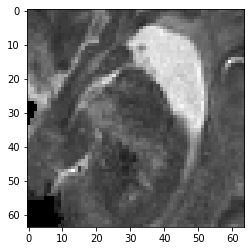

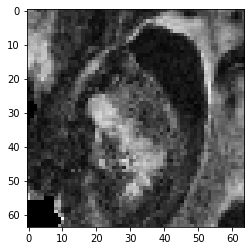

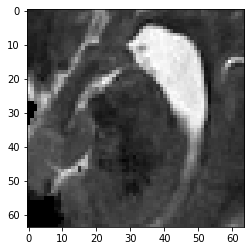

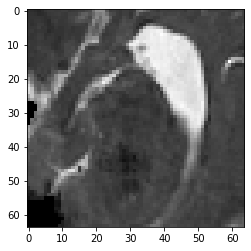

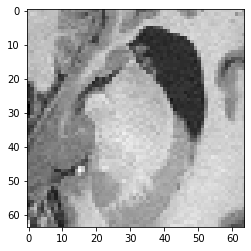

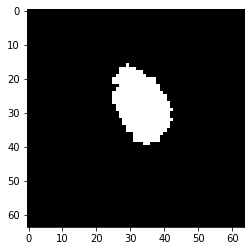

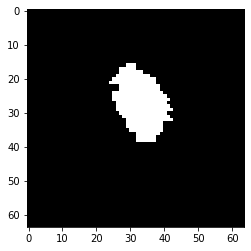

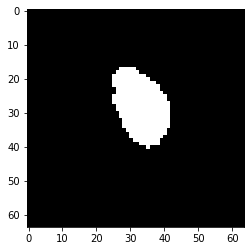

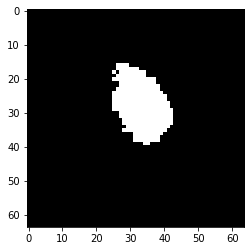

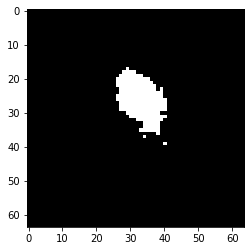

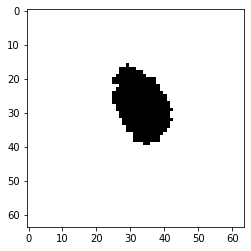

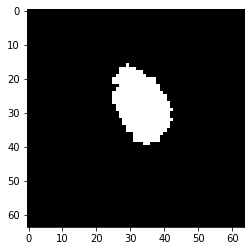

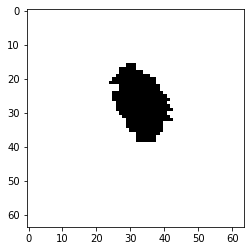

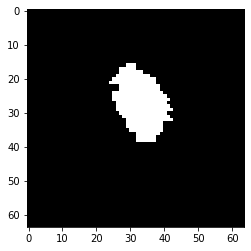

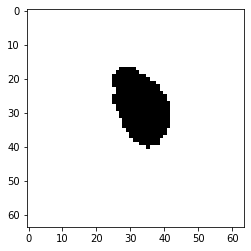

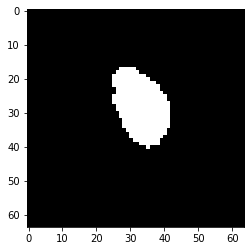

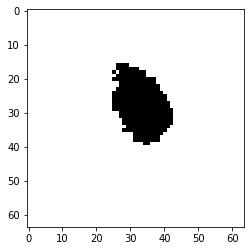

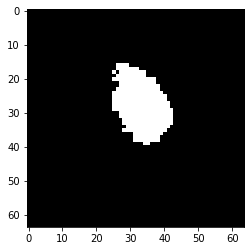

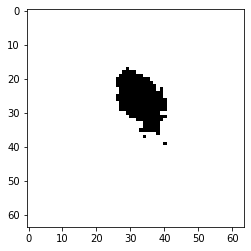

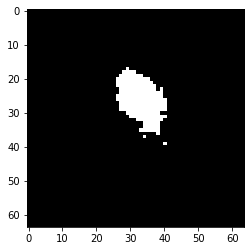

In [10]:
print('show input channels')
for channel in PATCHES_img:
    plt.figure()
    plt.imshow(channel,cmap='gray')
    
print('show masks')
for msk in PATCHES_msk:
    plt.figure()
    plt.imshow(msk,cmap='gray')
    
print('show masks_oh')
for msk in PATCHES_mskoh:
    for i in range(msk.shape[0]):
        plt.figure()
        plt.imshow(msk[i],cmap='gray')